In [17]:
import os
import json
import gzip
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from collections import Counter

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression

# 1 Video filtering

The first section of our code focuses on video filtering around the topic of `mental health` we propose. We adopt a 2-step filtering strategy, where we use snowball sampling based on keywords in the first stage, and further exclude irrelevant categories and unwanted videos in the second. Here's a detailed description of what we have done:

## 1.1. First stage: Snowball sampling based on keywords

### Method

1) We first design a list of keywords ourselves that is supposed to connect to the filed of mental health, e.g. `mental health`, `anxiety`, `depress`...
2) Since the dataset is extremely large, we read the files line by line and process them in a batch size of 200000. Three attributes are taken into account during processing, namely `description`, `tags` and `title`. If **at least two out of three text fields** contain a word in our designed word list, we assume that video is relevant and be retrieved.
3) After retrieving, we check the results by a wordcloud visualization and see if there is any insightful words that occur in the result but is not included in our designed keyword list. If such word exists, we iteratively add them to the list. Here some of the words we added include `sociopath`, `psycho`, etc.
4) Repeat step 1-3 to update the results until no new words can be found.

In [18]:
# keywords for mental health
# The matching algorithm only checks the existence of the given string, 
# so we could use "depress" to represent "depression",# "depressed",# "depressing", etc.

mental_word_list = [
    "mental health", "mental illness", "disorder",
    "solitude", "alone", "lonely", "loneliness",
    "depress",  # "depression",# "depressed",# "depressing",
    "stress", "anxiety", "anxious", # "stress", # "stressing",# "stressed" 
    "suicid", "trauma",
    "[^a-z0-9]ptsd[^a-z0-9]",
    "[^a-z0-9]emo[^a-z0-9]",
    "psycho",
    "psychiatr",
    "psychedelic",
    "sociopath",
]

mental_keywords = "|".join(mental_word_list)

### Comparing trend

It is necessary to extract videos belonging to other topics so that we could make a proper comparison between them. The topics we chose are `climate change`, and `gender equality`, which are all considered as a growing social issues today. In order to do so, we also designed a set of keywords list to extract their corresponding videos respectively.

In [19]:
word_lists_climate = [
    "climate change",
    "global warming",
    "air pollution",
    "greenhouse effect",
    "carbon emissions",
    "carbon footprint",
    "carbon tax"
]
climate_keywords = "|".join(word_lists_climate)

# keywords for gender quality
gender_word_list = [
    "gender equal", "gender inequal", "gender discriminat",
    "sex equal", "sex inqual", "sex discriminat",
    "sexis", "gender egalitari", "sexual egalitari", "sex egalitari",
    "sexual equal", "sexual inequal", "sexual discriminat",
    "sexual harass", "sexual assult",
    "feminis",  # "Feminism", "Feminist"
    "women right", "women's right", "woman right", "woman's right",
    "women power", "women's power", "woman power", "woman's power",
    "girl help girl", "girls help girls", "girl helps girl"
]
gender_keywords = "|".join(gender_word_list)

In [20]:
# Final keywords dictionary
keywords_dict = {
    "mental_health": mental_keywords,
    "gender_equality": gender_keywords,
    "climate_change": climate_keywords,
}

In [21]:
# Relevant videos retrieval
def df_filter(df_metadata: pd.DataFrame, keywords: str):
    """
    Function to build and filter dataframe.
    A record would be kept if at least two out of three text fields (description, tags, title) match with at least one keyword specifed above
    """
    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["description", "tags", "title", "upload_date"])

    filter_condition1 = df_meta["description"].str.lower().str.contains(keywords).astype(int)
    filter_condition2 = df_meta["tags"].str.lower().str.contains(keywords).astype(int)
    filter_condition3 = df_meta["title"].str.lower().str.contains(keywords).astype(int)

    # the fulfilled condition needs to be equal or above 2
    filter_condition = filter_condition1 + filter_condition2 + filter_condition3
    df_meta = df_meta[filter_condition >= 2]

    return df_meta.copy()

def get_counter(df_metadata: pd.DataFrame):
    """
    Count how many videos are uploaded per day.
    This is to calculate ratio for the following process.
    """
    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["upload_date"])

    df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"]).dt.to_period("D").astype(str)
    counter_dict = df_meta["upload_date"].value_counts().to_dict()
    
    return Counter(counter_dict)

In [ ]:
# initialize dataframe for all the topics we want to analyze
metadata_df = {}
for topic in keywords_dict.keys():
    metadata_df[topic] = []

tmp_metadata = []

# Specify the file path and batch size
file_path = './data/yt_metadata_en.jsonl.gz'
batch = 2000000

with gzip.open(file_path, mode="rb") as f:
    for idx, row in enumerate(tqdm(f, total=72924794)):
        json_dict = json.loads(row.decode("utf-8"))
        tmp_metadata.append(json_dict)

        # if the amount of data reaches the batch size
        # we transform them into dataframe and process at one time
        if (idx + 1) % batch == 0 and idx != 0:
            df_meta = pd.DataFrame(tmp_metadata)
            cur_counter = get_counter(df_meta)
            counter = counter + cur_counter

            # filter videos and add them to the respective topic list
            for topic, keywords in keywords_dict.items():
                metadata_df[topic].append(df_filter(df_meta, keywords))
                
            # clear the buffer to save space
            tmp_metadata = []
    
    # after the loop over, process and clear what's left in the buffer
    if tmp_metadata:
        df_meta = pd.DataFrame(tmp_metadata)
        cur_counter = get_counter(df_meta)
        counter = counter + cur_counter
        
        for topic, keywords in keywords_dict.items():
            metadata_df[topic].append(df_filter(df_meta, keywords))
        tmp_metadata = []

## 2. Second stage: Filter based on video category and eliminate unnecessary keywords
For the below block, we have done several additional filtering aiming for a more desired outcome.

1. We require that in the `title` of the video, at least one of keywords should exist, which is tighter than the `two out of three requirement` above.
2. We eliminate some videos belonging to categories like `Music`, `Movie` since we inspect the content of the videos and most of them are false positive. Till now, the categories we allow are included in the list `constrained_category`.
3. Specifically for `mental health` videos, we filter some of the undesired contents based on keywords like `monkey`, `malone`, for they show little relevance to the topic.
4. Finally, use a wordcloud figure and display our final results to validate the results we obtained so far.

Before filtering, there are 373939 videos
After filtering, there are 88828 videos


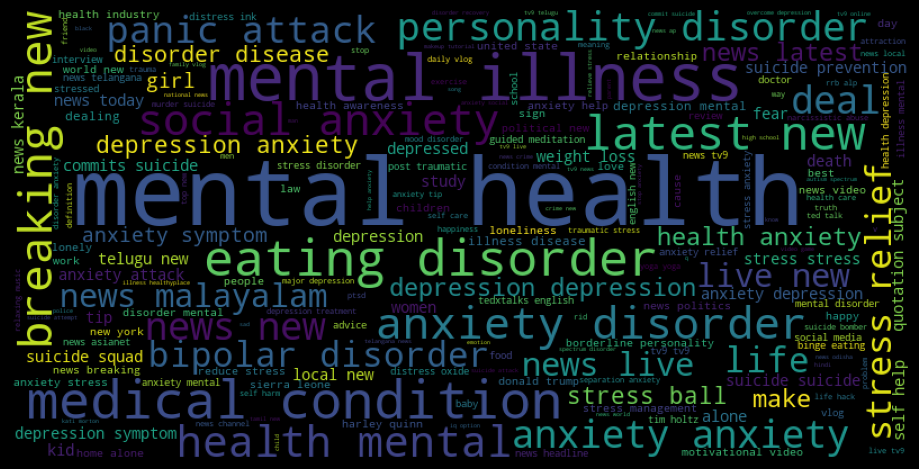

In [22]:
def filter_based_on_category_and_title(df: pd.DataFrame, category: list[str], keywords: str):
    # drop nan and filter nan
    df = df.dropna(subset=["description", "tags", "title", "upload_date", "categories"])
    df = df[df["categories"].isin(category)]
    
    # Ask title to contain keywords
    if keywords is not None:
        df = df[df["title"].str.lower().str.contains(keywords)]
        
    return df

df_meta_mental = pd.read_csv("./data/metadata_mental.csv")

# the restricted category we accept
constrained_category = ["Howto & Style", "Science & Technology", "People & Blogs", "Pets & Animals",
                        "Travel & Events", "Nonprofits & Activism", "News & Politics", "Education", "Nonprofits & Activism"] 

# second stage filter
print("Before filtering, there are %d videos"%len(df_meta_mental))
df_meta_mental = filter_based_on_category_and_title(df_meta_mental, constrained_category, mental_keywords)

# constrain on the time 2006.1 - 2019.9
# since data is a bit weird before and after the time span
df_meta_mental["upload_date"] = pd.to_datetime(df_meta_mental["upload_date"])
df_meta_mental = df_meta_mental[df_meta_mental["upload_date"].dt.date < datetime.date(2019, 10, 1)]
df_meta_mental = df_meta_mental[df_meta_mental["upload_date"].dt.date > datetime.date(2006, 1, 1)]

df_meta_mental = df_meta_mental[~df_meta_mental["tags"].str.lower().str.contains("monkey|malone|lonely planet")]
print("After filtering, there are %d videos"%len(df_meta_mental))


# display the results using a wordcloud
from wordcloud import WordCloud, STOPWORDS

tags = df_meta_mental["tags"].apply(lambda x: str(x).lower().replace(",", " "))
wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(' '.join(tags))

plt.figure(figsize=(9,6), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# save the result
df_meta_mental.to_csv("./data/metadata_mental_final.csv", index=False)

In [23]:
# sample some video content to show
sampled_df = df_meta_mental[["categories", "title"]].sample(frac=1).head(10)

fig = go.Figure(data=[go.Table(
    header=dict(values=['categories', 'title'],
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[sampled_df.categories.values, sampled_df .title.values], 
               fill_color='lavender',
               align='left'))
])

# fig.update_layout(
#     autosize=True,
#     width=800,
#     height=400,
# )

fig.show()
fig.write_html("./result/samples.html")

# 2 Trend analysis based on videos uploaded per month from 2006-2019

It is time to show how much videos about mental health are uploaded per month and their growth over the years.

## 2.1 Mental health trend

We display both video numbers and ratios throughout the year and applied a linear regression analysis to analyze its growing trend. We leave out the fluctuating period between 2006-2009 when doing the regression analysis and found the result is statistically significant, indicating a mild yet stable growing trend. To this end, we successfully demonstrate people's growing attention to the topic of mental health on YouTube.

In [42]:
def get_total_count(path, constrained_category, save_path):
    """
    Function to get total uploaded video number per date
    """
     
    # if not exist the file, read the feather file to get video numbers from all the constrained category we specified
    if not os.path.exists(save_path): 
        df_meta_all = pd.read_feather(path)
        df_meta_all = df_meta_all[df_meta_all["categories"].isin(constrained_category)]
        df_meta_all["upload_date"] = pd.to_datetime(df_meta_all["upload_date"]).dt.to_period("M")
        
        total_count_df = df_meta_all["upload_date"].value_counts().to_frame()
        total_count_df["view_count"] = df_meta_all.groupby("upload_date")["view_count"].sum()
        total_count_df["like_count"] = df_meta_all.groupby("upload_date")["like_count"].sum()
        total_count_df["popularity"] = total_count_df["like_count"] + total_count_df["view_count"]
        
        # sort the statistics according to the upload time
        total_count_df.sort_index(inplace=True)
        total_count_df.to_csv(save_path, index=True)
        
    # load the file
    total_count_df = pd.read_csv(save_path, index_col=0)
    total_count_df.index = pd.to_datetime(total_count_df.index).to_period('M')
        
    # Also should be in the time span we specified
    total_count_df = total_count_df[total_count_df.index.to_timestamp().date < datetime.date(2019, 10, 1)]
    total_count_df = total_count_df[total_count_df.index.to_timestamp().date > datetime.date(2006, 1, 1)]
    
    return total_count_df

def get_proportion(dataframe: pd.DataFrame, total_count: pd.Series):
    """
    Function to get the proportion of current topic videos to all videos uploaded in the same month
    """
    df = dataframe.copy()

    # divide current video number by total video number to get the ratio
    df["upload_month"] = pd.to_datetime(df["upload_date"]).dt.to_period('M')
    cur_count = df["upload_month"].value_counts()
    cur_count.sort_index(inplace=True)
    ratio = cur_count.divide(total_count, fill_value=0)
    ratio.index = ratio.index.to_timestamp()

    return ratio

# aggregate based on upload time and plot the histogram
def transform_for_histplot(dataframe: pd.DataFrame):
    """
    Aggregate record numbers monthly based on upload_date
    Return sorted histogram series
    """
    df = dataframe.copy()
    df.upload_date = pd.to_datetime(df.upload_date)
    df['upload_month'] = df['upload_date'].dt.to_period('M')
    df_hist = df['upload_month'].value_counts().sort_index()
    df_hist.index = df_hist.index.to_timestamp()
    return df_hist

In [43]:
# get ratio and number histogram
total = get_total_count("./data/yt_metadata_helper.feather", constrained_category, "./data/total_constrained.csv")
mental_hist = transform_for_histplot(df_meta_mental)
mental_ratio = get_proportion(df_meta_mental, total["count"])

# perform a linear regression analysis
import statsmodels.formula.api as smf
mental_ratio = mental_ratio.to_frame(name="ratio")

mental_ratio.reset_index(inplace=True)
mental_ratio.reset_index(inplace=True)
mental_ratio.rename(columns={"index": "date", "level_0": "index"}, inplace=True)

mental_ratio_LR = mental_ratio[mental_ratio.date.dt.date > datetime.date(2010, 1, 1)].copy()

mod = smf.ols(formula='ratio ~ index', data=mental_ratio_LR)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     31.26
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.57e-07
Time:                        13:14:06   Log-Likelihood:                 768.14
No. Observations:                 116   AIC:                            -1532.
Df Residuals:                     114   BIC:                            -1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0025   9.97e-05     24.595      0.0

In [44]:
# use scikit learn to predict the regression result and draw the line
model = LinearRegression()

# Fitting the model with the data
model.fit(np.array(range(len(mental_ratio_LR))).reshape(-1,1), mental_ratio_LR.ratio.values)

# Making predictions
y_pred = model.predict(np.array(range(len(mental_ratio_LR))).reshape(-1,1))

In [47]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# draw the absolute mental health video number with bar chart
fig.add_trace(
    go.Bar(x=mental_hist.index, y=mental_hist.values, name="Number"),
    secondary_y=False,
)

# draw the ratio with line
fig.add_trace(
    go.Scatter(x=mental_ratio.date, y=mental_ratio.ratio, name="Ratio"),
    secondary_y=True,
)

# draw regression result with dashed line
fig.add_trace(
    go.Scatter(x=mental_ratio_LR.date, y=y_pred, name="LR Trend", line=go.scatter.Line(dash='dash')),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Mental health videos uploaded per month from 2006-2019"
)

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Number", secondary_y=False)
fig.update_yaxes(title_text="Ratio", secondary_y=True)

fig.show()
fig.write_html("./result/ratio.html")

/Users/scbai/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## 2.2 Comparing the trends

### 2.2.1 Ratio
Remember our compared topics are : `gender equality` and `climate change`. We only plot their ratio throughout the years and put it into the log scales for a clearer comparison.

It is rather surprising to see that none of the comparing trends shows a dramatic increase for their ratios. Nonetheless, mental health issues receives more attention than the comparing topics.

Also, We hypothesize that maybe remaining a stable uploading ratio already means a sustained and consistent attention indicating it is one of the social trend. The upward trend doesn't show because the ranges of videos on YouTube are increasingly explored making the total numbers of videos rises comparably faster than videos from the specific topic.

In [48]:
def load_dataframe(topics: list):
    """
    Load csv files of other topics into dataframes
    """
    df_dict = {}
    for topic in topics:
        df_dict[topic] = pd.read_csv("./data/metadata_%s.csv"%topic)
        # Also filter the videos based on the constrained category
        df_dict[topic] = filter_based_on_category_and_title(df_dict[topic], constrained_category, keywords_dict[topic])#None)
    return df_dict

compared_topics = ["gender_equality", "climate_change"]
df_dict = load_dataframe(compared_topics)

In [49]:
def plot_by_group(ratio_dict, save_path, title):
    
    fig = make_subplots()
    
    # plot the ratios for the comparing topics
    for topic in ratio_dict:
        fig.add_trace(
            go.Scatter(x=ratio_dict[topic].index, y=ratio_dict[topic].values, name=topic),
        )
        
    
    # Add figure title
    fig.update_layout(
        title_text=title
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text="Year")
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Ratio")
    fig.update_yaxes(type="log")
    
    fig.show()
    fig.write_html(save_path)
    # Plot the first subplot

# draw the comparison
ratio_dict = {}
for topic in compared_topics:
    ratio_dict[topic] = get_proportion(df_dict[topic], total["count"])

mental_ratio = mental_ratio.set_index("date", drop=True)["ratio"]
ratio_dict["mental_health"] = mental_ratio

plot_by_group(ratio_dict, "./result/comparison.html", "Comparison of videos uploaded per month from 2006-2019")

### 2.2 Popularity

Ratio of the uploaded video number is not everything, what about the popularity of the videos? Here, we define the popularity score as `popularity_score` = `view_count` + `like_count`, and let's compare the ratio of the popularity score of the videos:

In [30]:
def get_popular_proportion(dataframe: pd.DataFrame, total_count: pd.Series):
    """
    Function to get the proportion of current topic videos to all videos uploaded in the same month
    """
    df = dataframe.copy()

    # divide current video number by total video number to get the ratio
    df["upload_month"] = pd.to_datetime(df["upload_date"]).dt.to_period('M')
    popular_df = df.groupby("upload_month")["view_count"].sum() + df.groupby("upload_month")["like_count"].sum()
    popular_df.sort_index(inplace=True)
    popular_ratio = popular_df.divide(total_count, fill_value=0)
    popular_ratio.index = popular_ratio.index.to_timestamp()

    return popular_ratio

popular_dict = {}
for topic in compared_topics:
    popular_dict[topic] = get_popular_proportion(df_dict[topic], total["popularity"])

mental_popular = get_popular_proportion(df_meta_mental, total["popularity"])
popular_dict["mental_health"] = mental_popular

plot_by_group(popular_dict, "./result/popular.html", "Comparison of popularity of videos uploaded per month from 2006-2019")

# 3. Explore predominant category and the most mentioned group of people in mental health videos

In this section ,we aim to delve deep inside the trend of mental health videos and would like to study two problems:
1) What is the most frequently mentioned group of people? Is teenager problems more mentioned or women?
2) Among all the videos, what is the most frequently mentioned mental issues? Is it `disorder` or `suicide`, etc?
3) Finally, throughout the years, do the situation varies?

To do this We divide the keywords into several groups to our best knowledge, and calculate their frequency according to their appearance in the mental health videos.

## 3.1 Affected people groups

We count the frequency of `man`, `woman`, `teenager` and `senior`. And see that throughout all the years, mental issues regarding `teenager` remains the biggest problem, followed by `woman` and `man`.

In [31]:
def get_proportion(dataframe, types):
    df_meta = dataframe.copy()
    df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"])
    df_meta = df_meta[df_meta["upload_date"].dt.date < datetime.date(2019, 1, 1)]
    
    # initialize, keys are types, values are lists of proportion over the years
    types_proportion_all = {}
    for t in types.keys():
        types_proportion_all[t] = []
    types_proportion_all["general"] = []
    
    # group by years
    years = []
    for year, df_group in df_meta.groupby(df_meta["upload_date"].dt.year):
        years.append(year)
        types_counter, _ = count_type(df_group, types)
        types_proportion = list(types_counter.values())
        for mental_type, proportion in zip(list(types_counter.keys()), types_proportion):
            types_proportion_all[mental_type].append(proportion)
    
    return types_proportion_all, years

def count_type(dataframe: pd.DataFrame, types: dict):
    """
    Count the occurence of each type
    If none of the types is detected, then it belongs to the general type
    """
    df = dataframe.copy()

    df["text"] = df["title"] +  " " + df["tags"] + " " + df["description"]
    df["is_general"] = 1

    keywords_counter = Counter()
    count_matrix = []

    for m_type, keywords in types.items():
        if_contains_keywords = df["text"].str.lower().str.contains(keywords).astype(int)
        count_matrix.append(if_contains_keywords.values)
        
        keywords_counter[m_type] = if_contains_keywords.sum()
        # df.loc[if_contains_keywords, "is_general"] = 0

    count_matrix = np.vstack(count_matrix)

    return keywords_counter, count_matrix

def draw(df_meta, types: dict, title: str, save_path):
    
    # get types and proportions for each group
    types_counter, matrix = count_type(df_meta, types)
    types_proportion, years = get_proportion(df_meta, types)

    fig = make_subplots(rows=1, cols=2, column_widths=[0.4, 0.6], horizontal_spacing=0.15)
    fig.add_trace(go.Bar(x=list(types_counter.keys()), y=list(types_counter.values())), row=1, col=1)
    
    # we do not want to plot the `general` group anymore, as it contains little information
    for mental_type, proportions in types_proportion.items():
        if mental_type == "general":
            continue
        fig.add_trace(go.Line(x=years, y=proportions, name=mental_type,), row=1, col=2)
        
    # Format the figure
    for trace in fig['data']: 
        if(trace['name'] not in list(types.keys())):
            trace['showlegend'] = False
    
    fig.update_layout(title_text=title)
    
    fig.update_xaxes(title_text="Type", row=1, col=1)
    fig.update_yaxes(title_text="Related video number", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_yaxes(title_text="Related video number over the years", row=1, col=2)

    fig.show()
    fig.write_html(save_path)
    
    return matrix
    
# people groups we divide, note they are not mutually exclusive!
people_types = {
    "man": ["[^a-z0-9]man[^a-z0-9]", "[^a-z0-9]men[^a-z0-9]", "[^a-z0-9]husband[^a-z0-9]", "[^a-z0-9]father[^a-z0-9]", "[^a-z0-9]dad[^a-z0-9]", "gentleman", "gentlemen", "[^a-z0-9]male[^a-z0-9]", "masculine"],
    "woman": ["woman", "women", "wife", "[^a-z0-9]mom[^a-z0-9]", "[^a-z0-9]mother[^a-z0-9]", "pregnant", "[^a-z0-9]lady[^a-z0-9]", "[^a-z0-9]mrs[^a-z0-9]", "female", "feminine",],
    "teenager": ["children", "child", "baby", "young", "teenager", "[^a-z0-9]teen[^a-z0-9]", "pupil",  "school", "student", "college", "[^a-z0-9]grad[^a-z0-9]", "boy", "girl"],
    "senior": ["senior", "old people", "old citizen", "grandfather", "grandmother", "grandmom", "grandparents", "aging", "retire", "elder", "veteran"],
}

for m_type, keywords in people_types.items():
    people_types[m_type] = "|".join(keywords)
  
df_meta_mental = pd.read_csv("./data/metadata_mental_final.csv")  
matrix_people = draw(df_meta_mental, people_types, "Related videos with respect to different groups of people", "./result/people.html")

/Users/scbai/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## 3.2 mental category

Now, let's see the most mentioned category. And we can see `stress` is the most mentioned problem, followed by `suicide` and `depress`. They all show a similar trend of increase all these years.

In [32]:
# mental health types
mental_types = {
    # "general": ["mental health", "mental illness", "[^a-z0-9]emo[^a-z0-9]", "psycho", "psychiatr"],
    "lonely": ["solitude", "alone", "lonely", "loneliness"],
    "depress": ["depress"],
    "stress": ["stress",  "anxiety", "anxious"],
    "suicide": ["suicid"],
    "trauma": ["trauma", "ptsd"],
    "disorder": ["disorder"], # new
}

for m_type, keywords in mental_types.items():
    mental_types[m_type] = "|".join(keywords)
    
df_meta_mental = pd.read_csv("./data/metadata_mental_final.csv")  
matrix_mental = draw(df_meta_mental, mental_types, "Related videos with respect to different types of mental issues", "./result/category.html")

/Users/scbai/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## 3.3 Heatmap
Let's look at the intersection of the above two results! We use a heatmap to display the affected number. Interestingly, stress is the most common mental problems affecting people of all ages, especially teenagers.

In [ ]:
# Plot the heatmap using matrix_people * matrix_mental
import plotly.express as px
fig = px.imshow(matrix_people.dot(matrix_mental.T),
                labels=dict(x="Mental Issues", y="People", color="Number"),
                x=list(mental_types.keys()),
                y=list(people_types.keys())
               )
fig.update_xaxes(side="top")
fig.show()
fig.write_html("./result/heatmap.html")

# 4. Sentiment analysis

In [ ]:
from transformers import pipeline, DistilBertTokenizer

# Initialize a sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 512  # Maximum length for DistilBERT

def analyze_sentiment(text):
    try:
        # Truncate the text
        inputs = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")
        # Convert back to text (truncate at the maximum length)
        truncated_text = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
        # Get sentiment
        return sentiment_pipeline(truncated_text)[0]
    except Exception as e:
        print(e)
        return np.nan

metadata_df['description_sentiment'] = metadata_df['description'].apply(analyze_sentiment)

# export the dataframe to csv file
metadata_df.to_csv('metadata_mental_final_sentiment.csv', index=False)

/Users/doris/anaconda3/envs/cs401/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


In [ ]:
import json
def string_to_dict(s):
    if pd.isna(s):
        return None

    try:
        # Replace single quotes with double quotes
        s = s.replace("'", '"')
        # Convert the string to a dictionary
        return json.loads(s)
    except json.JSONDecodeError:
        # Return None if json.loads fails
        return None

# Convert the string representation of the dictionary into an actual dictionary, handling NaN values and malformed strings
if(type(metadata_df['description_sentiment'][0]) == str):
    metadata_df['description_sentiment'] = metadata_df['description_sentiment'].apply(string_to_dict)


# Function to extract the 'label' key
def extract_label(d):
    try:
        if 'label' in d:
            return d['label']
        return None
    except:
        return None

# Extract the 'label' key
metadata_df['label'] = metadata_df['description_sentiment'].apply(extract_label)

# Function to extract the 'score' key
def extract_score(d):
    try:
        if 'score' in d:
            return d['score']
        return None
    except:
        return None

# Extract the 'score' key
metadata_df['score'] = metadata_df['description_sentiment'].apply(extract_score)


In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Assuming 'metadata_df' is your DataFrame with the 'label' and 'score' columns

# Separate the scores based on the sentiment label
positive_scores = metadata_df[metadata_df['label'] == 'POSITIVE']['score']
negative_scores = metadata_df[metadata_df['label'] == 'NEGATIVE']['score']

# Creating histograms for positive and negative scores
negative_trace = go.Histogram(
    x=negative_scores,
    opacity=0.45,
    name='Negative Scores',
    marker=dict(color='blue')
)


positive_trace = go.Histogram(
    x=positive_scores,
    opacity=0.45,
    name='Positive Scores',
    marker=dict(color='red')
)



# Layout settings
layout = go.Layout(
    title='Distribution of Sentiment Scores in Mental Health Videos',
    xaxis=dict(title='Sentiment Score'),
    yaxis=dict(title='Frequency'),
    barmode='overlay'
)

# Create the figure and plot
fig = go.Figure(data=[positive_trace, negative_trace], layout=layout)
fig.show()
fig.write_html("./sentiment_graph/distribution_overall.html")

The overwhelming majority of descriptions have been classified with high sentiment scores, indicating a prevalence of high prediction confidence resulted from strong emotional content. 

The red bars, representing negative sentiment, show a significant number of descriptions with scores clustering near 1.0, suggesting a high degree of negative sentiment in the content. Simultaneously, the green bars for positive sentiment are much fewer in number, yet they also cluster towards the higher end of the score range. 

We can see the intense nature of discussions and narratives around mental health topics on YouTube, where expressions of both support and struggle could be expected to elicit strong emotional responses. 

The stark contrast between the quantities of negative and positive sentiments may also point to a tendency for these videos to address challenging or problematic aspects of mental health more so than positive outcomes or support.

## 4.1 Sentiment Analysis Over Time
This analysis will reveal how the sentiment expressed in video descriptions has changed over the period for which you have data.

In [ ]:

# Convert 'upload_date' to datetime and sort the DataFrame
metadata_df['upload_date'] = pd.to_datetime(metadata_df['upload_date'])
metadata_df.sort_values('upload_date', inplace=True)

# Group by 'upload_date' and calculate the daily sentiment score percentages
daily_sentiment_counts = metadata_df.groupby(['upload_date', 'label']).size().unstack(fill_value=0)
daily_totals = daily_sentiment_counts.sum(axis=1)
daily_sentiment_percentages = daily_sentiment_counts.divide(daily_totals, axis=0)

# Reshape the DataFrame for plotting
daily_sentiment_percentages = daily_sentiment_percentages.stack().reset_index(name='percentage')


# Create a scatter plot with Plotly Express
fig = px.scatter(daily_sentiment_percentages, x='upload_date', y='percentage', 
                 color='label', 
                 title='Percentage of Total Mental Health Videos by Sentiment Score Over Time',
                 labels={'upload_date': 'Date', 'percentage': 'Percentage of Total Videos'},
                 opacity=0.5)

# Update layout for better visualization
fig.update_layout(legend_title_text='Sentiment', xaxis=dict(showgrid=True), yaxis=dict(showgrid=True))

# Show the plot
fig.show()
fig.write_html("./sentiment_graph/distribution_time.html")


Distribution of Sentiments: There is a clear distinction between positive and negative sentiment scores over time. The plot shows a dense concentration of both positive and negative sentiments, with positive sentiments depicted in orange and negative sentiments in blue.

Sentiment Over Time: There doesn't appear to be a stark trend indicating a shift towards more positive or negative sentiment over the years. Both sentiments are well-represented throughout the time period. However, there is a visible density of sentiment expression that remains fairly consistent over time.

Data Clustering: A cluster of data points, especially for positive sentiments, is visible at the lower percentage range, which indicates that on most days, a certain fraction of videos have positive sentiment scores. Negative sentiments seem to be more spread out, potentially suggesting a wider variation in the proportion of videos receiving negative sentiment on any given day.

Potential Overplotting: The graph suggests a potential issue with overplotting, where multiple data points overlap, especially in areas of high data density. This can make it challenging to discern the exact distribution or to identify outliers. Utilizing transparency (alpha blending) can help to mitigate this effect and better reveal the underlying data distribution.


### Sentiment Analysis with Increasing Popularity

This analysis assesses whether there's a correlation between the sentiment of video descriptions and their popularity metrics, such as views, likes, and comments.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate a popularity score
metadata_df['popularity_score'] = metadata_df['view_count'].fillna(0) + metadata_df['like_count'].fillna(0)

# Ensure there are no zero or negative values before taking log
metadata_df['popularity_score'] = metadata_df['popularity_score'].replace(0, np.nan)
metadata_df.dropna(subset=['popularity_score'], inplace=True)

# Define bins in log-space
min_popularity = np.log10(metadata_df['popularity_score'].min())
max_popularity = np.log10(metadata_df['popularity_score'].max())
popularity_bins = np.logspace(min_popularity, max_popularity, num=200)

# Bin the popularity scores with the log bins
metadata_df['popularity_bin'] = pd.cut(metadata_df['popularity_score'], bins=popularity_bins, labels=range(len(popularity_bins)-1))

# Calculate the midpoint of each bin for plotting
def calculate_midpoint(bin_index):
    if bin_index < len(popularity_bins) - 1:
        return (popularity_bins[bin_index] + popularity_bins[bin_index + 1]) / 2
    return np.nan

metadata_df['popularity_bin_mid'] = metadata_df['popularity_bin'].apply(calculate_midpoint)

# Group by the mid-point of popularity bins and calculate the average sentiment score
average_sentiment_by_popularity = metadata_df.groupby('popularity_bin_mid')['adjusted_score'].mean().reset_index()

# Convert 'popularity_bin_mid' to a numeric type if necessary
average_sentiment_by_popularity['popularity_bin_mid'] = pd.to_numeric(average_sentiment_by_popularity['popularity_bin_mid'], errors='coerce')

# Create a line plot with Plotly Express
fig = px.line(average_sentiment_by_popularity, x='popularity_bin_mid', y='adjusted_score', 
              title='Average Sentiment Score of Mental Health Videos by Popularity Score',
              labels={'popularity_bin_mid': 'Popularity Score (Bin Mid-Point)', 'adjusted_score': 'Average Sentiment Score'},
              log_x=True,  # Set the x-axis to a logarithmic scale
             )

# Add points to the line plot for clarity
fig.add_scatter(x=average_sentiment_by_popularity['popularity_bin_mid'], y=average_sentiment_by_popularity['adjusted_score'], mode='markers')

# Update layout for better visualization
fig.update_layout(xaxis=dict(showgrid=True, type='log', gridcolor='LightPink', gridwidth=0.5),
                  yaxis=dict(showgrid=True, gridcolor='LightBlue', gridwidth=0.5))

# Show the plot
fig.show()
fig.write_html("./sentiment_graph/distribution_popularity.html")

/var/folders/hl/ywgzj5kj7x960vjr6rcrz32h0000gn/T/ipykernel_2126/73929243.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



As we move towards the higher end of the popularity spectrum, there is increased variability in sentiment scores. This trend indicates that videos with very high popularity scores tend to elicit more varied emotional responses. This variability could be due to a number of factors, such as a broader audience with diverse opinions engaging with the content, or it could reflect the polarizing nature of more popular content.

The most popular videos, as indicated by the higher end of the popularity score axis, show several instances of stronger sentiment scores. This suggests that content that garners a high number of views and likes tends to evoke stronger sentiments. 
This could be interpreted in several ways: 
1. videos that provoke a strong emotional response may become popular because they are more engaging
2. or it could be that popular videos receive more scrutiny and therefore a more pronounced sentiment reaction.
3. or they might be videos that have become popular due to controversial content, leading to strong sentiment expressions.


There is a noticeable stability in the average sentiment score across the low to medium popularity score range. But we also need to take care, as in the middle part they are following a slightly decreasing trend. We can deeper look into this, by performing a regression in the [10^2, 10^5] range.

In [ ]:
from sklearn.linear_model import LinearRegression

# Convert 'popularity_bin_mid' to numeric type for comparison
average_sentiment_by_popularity['popularity_bin_mid'] = pd.to_numeric(average_sentiment_by_popularity['popularity_bin_mid'])

# Define the range for the 'middle part' of the data
lower_bound = 1e1  # Adjust as needed
upper_bound = 1e6  # Adjust as needed

# Filter the 'middle part' of the data
middle_part_df = average_sentiment_by_popularity[(average_sentiment_by_popularity['popularity_bin_mid'] >= lower_bound) & 
                                                 (average_sentiment_by_popularity['popularity_bin_mid'] <= upper_bound)]

# Prepare the data for regression
X = np.log(middle_part_df['popularity_bin_mid'].values.reshape(-1, 1))  # Log-transform the Features
y = middle_part_df['adjusted_score'].values  # Target


# Perform linear regression on the filtered 'middle part' of the data
regression_model = LinearRegression()
regression_model.fit(X, y)

# Define the range for plotting the regression line
plotting_range = np.linspace(np.log(lower_bound), np.log(upper_bound), 100).reshape(-1, 1)
predicted_scores_plotting_range = regression_model.predict(plotting_range)

# Create a scatter plot with Plotly
scatter_trace = go.Scatter(
    x=average_sentiment_by_popularity['popularity_bin_mid'], 
    y=average_sentiment_by_popularity['adjusted_score'], 
    mode='markers',
    name='Data'
)

# Create a line trace for the regression line within the specified bounds
regression_trace = go.Scatter(
    x=np.exp(plotting_range).flatten(), 
    y=predicted_scores_plotting_range, 
    mode='lines',
    name='Regression Line',
    line=dict(color='red', width=2)
)

# Layout settings
layout = go.Layout(
    title='Average Sentiment Score of Mental Health Videos by Popularity Score',
    xaxis=dict(title='Popularity Score (Bin Mid-Point)', type='log', showgrid=True),
    yaxis=dict(title='Average Sentiment Score', showgrid=True),
    legend=dict(x=0.5, y=1.0)
)

# Creating the figure
fig = go.Figure(data=[scatter_trace, regression_trace], layout=layout)

# Show the plot
fig.show()
fig.write_html("./sentiment_graph/distribution_popularity_regression.html")



There is a discernible downward trend in the average sentiment score of mental health video descriptions as they ascend in popularity, in the mid-range of the popularity spectrum. This trend suggests a nuanced shift in the tone of video descriptions: as videos garner more views and potentially reach a wider audience, their descriptions may increasingly reflect a more sober or realistic portrayal of mental health issues, which could be perceived as less positive.

This gradual decline in sentiment with rising popularity could indicate that creators with a larger audience may feel a responsibility to present a more multifaceted and perhaps less idealized view of mental health, aligning with a broader societal trend towards authenticity and acknowledgment of mental health complexities. 

Connecting this observation to the previous analysis, the shift in sentiment could be indicative of content creators' response to audience expectations, suggesting a deliberate move away from simply uplifting content towards material that engages with the nuanced realities of mental health. This pattern could be driven by a genuine desire to contribute to the destigmatization of mental health issues, rather than a mere pursuit of popularity or trend-following. 


## 4.2 Topic detection

LDA, or Latent Dirichlet Allocation, is a type of statistical model used for discovering the abstract "topics" that occur in a collection of documents. It's a form of unsupervised machine learning that organizes a corpus of text documents into topics, which are distributions of words that capture the essence of thematic subjects.

We define "top videos" as the 500 videos with highest popularity score (view number + like number) we use above.By diving into the behaviors of these videos, we may figure out

In [ ]:
mental_word_list = [
    "mental health",
    "mental illness",
    "solitude",
    "alone",
    "lonely",
    "loneliness",
    "depress",  # "depression",# "depressed",# "depressing",
    "depression",
    "stress",  # "stress", # "stressing",# "stressed"
    "anxiety",
    "anxious",
    "suicide",
    "suicidal",
    "trauma",
    "ptsd",
    "[^a-z0-9]emo[^a-z0-9]",
    "psycho",
    "psycholog[^a-z0-9]",
    "psychiatr",
    "disorder" # new
]

mental_keywords = "|".join(mental_word_list)

In [ ]:
# Select out the top videos
top_videos = metadata_df.sort_values(by='popularity_score', ascending=False).head(500)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from plotly.subplots import make_subplots


text_data = top_videos['title'] 

# Extend the default stop words list with your custom words
numbers_stop_words = [str(i) for i in range(100)]
custom_stop_words = ['com', 'www', 'http', 'https', 'youtube', 'youtu', 'instagram', 'twitter', 'facebook', 'video', 'videos', 'subscribe', 'watch', 'thanks', 'like', 'follow', 'channel', 'tutorial', 'crash', 'course', 'makeup', 'miniature','toy', 'toys', 'slime', 'ball', 'balls', 'creative', 'cutting', 'homemade', 'squishy', 'diy', 'crafts', 'make', 'making', 'decoration', 'list', 'playlist', 'music', 'yoga', 'home', 'harley', 'quinn','squad', 'joker', 'hindi', 'dog', 'dogs'] + list(CountVectorizer(stop_words='english').get_stop_words()) + numbers_stop_words
custom_stop_words += mental_word_list


vectorizer = CountVectorizer(stop_words=custom_stop_words)
text_vectorized = vectorizer.fit_transform(text_data)

lda = LatentDirichletAllocation(n_components=10) # Choose an appropriate number of topics
lda.fit(text_vectorized)

# Displaying topics
feature_names = vectorizer.get_feature_names_out()

# Number of top words to display for each topic
n_top_words = 10

# Prepare the figure with dropdown for selecting topics
fig = make_subplots(rows=1, cols=1)

# Create traces for each topic
traces = []
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[-n_top_words:][::-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    print(f'Topic {topic_idx}: {", ".join(top_features)}')  # print out the top topics

    trace = go.Bar(
        x=top_features,
        y=weights,
        name=f'Topic {topic_idx}'
    )
    traces.append(trace)

# Add all traces to the figure, but only one will be visible at a time
for i, trace in enumerate(traces):
    fig.add_trace(
        trace,
        row=1, col=1
    )

# Make only the first trace visible
for i in range(len(traces)):
    fig.data[i].visible = False
fig.data[0].visible = True

# Create a dropdown menu to select topics
buttons = []
for i, trace in enumerate(traces):
    button = dict(
        label=f"Topic {i}",
        method="update",
        args=[{"visible": [False] * len(traces)},
              {"title": f"Top words in Topic {i}"}],
    )
    button["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    buttons.append(button)

fig.update_layout(
    showlegend=False,
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ],
    title=f"Top words in Topic 0",
    xaxis=dict(title='Words'),
    yaxis=dict(title='Weights'),
)

# Show the figure
fig.show()
fig.write_html("./sentiment_graph/lda_topic.html")


Topic 0: stories, real, eating, psychopath, documentary, case, test, personality, room, attempt
Topic 1: psychological, hacks, phone, life, ladki, tips, easy, love, cute, projects
Topic 2: mixing, satisfying, bought, store, relieving, zen, garden, desk, new, best
Topic 3: left, live, kids, bags, learn, cat, slippery, tell, satisfying, real
Topic 4: giant, mesh, meditation, orbeez, open, stressed, mini, satisfying, eating, eggs
Topic 5: squish, old, open, puppy, year, doctor, girl, people, boy, big
Topic 6: open, school, supplies, sneak, class, reliever, ways, kids, woman, psychology
Topic 7: psychological, super, illness, mental, left, tips, ladki, ear, psychology, giant
Topic 8: old, brain, prank, relaxing, rare, year, mental, sex, knife, disorders
Topic 9: psychology, vs, kids, experiment, man, girls, editing, picsart, funny, disorders


/Users/doris/anaconda3/envs/cs401/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['emo', 'health', 'illness', 'mental', 'psycholog', 'z0'] not in stop_words.



Themes like "stories, real, eating, psychopath" (Topic 0) and "psychological, hacks, phone, life" (Topic 1) suggest a blend of personal narratives and psychological insights. These topics likely feature real-life stories and case studies, providing viewers with relatable content that delves into personal experiences and psychological phenomena. Such content often resonates deeply, offering both education and a sense of connection.

On a more practical note, topics involving "mixing, satisfying, bought, store" (Topic 2), "left, live, kids, bags" (Topic 3), and "giant, mesh, meditation" (Topic 4) seem to focus on activities and practices related to well-being, stress relief, and meditation. These videos could be offering viewers tangible methods to manage stress and anxiety, contributing to a discourse around self-care and mental wellness.

Education and awareness also emerge as key themes, especially in topics like "open, school, supplies, sneak" (Topic 6) and "psychology, vs, kids, experiment" (Topic 9). These likely cover educational content, psychological experiments, and discussions aimed at raising awareness about mental health issues, especially among younger audiences.

A notable aspect is the intersection of mental health with other areas of life and societal issues, as seen in topics like "old, brain, prank, relaxing" (Topic 8) and "squish, old, open, puppy" (Topic 5). These topics suggest a blend of mental health discussions with other life aspects such as aging, brain health, and even humor, reflecting the pervasive nature of mental health across various life domains.

Finally, topics like "psychological, super, illness, mental" (Topic 7) indicate a focus on more serious aspects of mental health, including illness, therapy, and psychological theories. This shows a commitment to addressing mental health issues in a substantive and educational manner.


Overall, the topics extracted from YouTube's mental health content reveal a dynamic and diverse conversation. From personal stories and practical tips to educational content and serious discussions on mental illnesses, these topics collectively contribute to a richer, more comprehensive dialogue on mental health, catering to a wide range of viewer interests and needs, instead of merely trend-following.

# 5. Time Series

In [ ]:
# Loading the dataset
folder = "./data/"
df_timeseries = pd.read_csv(folder + "df_timeseries_en.tsv", sep="\t")

# Convert 'datetime' column to datetime object
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# Displaying the dataset
display(df_timeseries)



channel            category   datetime  \
0         UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-03   
1         UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-10   
2         UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-17   
3         UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-24   
4         UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation 2017-07-31   
...                            ...                 ...        ...   
18872494  UC0UeVA9YHpOEr_Ng442xiRw              Gaming 2019-09-02   
18872495  UC0UeVA9YHpOEr_Ng442xiRw              Gaming 2019-09-09   
18872496  UC0UeVA9YHpOEr_Ng442xiRw              Gaming 2019-09-16   
18872497  UC0UeVA9YHpOEr_Ng442xiRw              Gaming 2019-09-23   
18872498  UC0UeVA9YHpOEr_Ng442xiRw              Gaming 2019-09-30   

                 views    delta_views          subs   delta_subs  videos  \
0         2.024946e+05       0.000000    650.222222     0.000000       5   
1         3.940857e+05  191591.111111   1046.000000   395.777778       6   
2         8.353938e+05  441308.083333   1501.500000   455.500000       6   
3         1.104577e+06  269183.250000   1750.000000   248.500000       6   
4         1.284406e+06  179828.600000   2008.300000   258.300000       6   
...                ...            ...           ...          ...     ...   
18872494  6.012938e+06  232418.277778  61268.611111  1305.611111     278   
18872495  6.244579e+06  231640.888889  62631.666667  1363.055556     287   
18872496  6.480902e+06  236322.933333  64010.000000  1378.333333     294   
18872497  6.745317e+06  264415.200000  65480.000000  1470.000000     301   
18872498  6.987738e+06  242420.771429  66542.857143  1062.857143     308   

          delta_videos  activity  
0                    0         3  
1                    1         1  
2                    0         1  
3                    0         0  
4                    0         0  
...                ...       ...  
18872494             2        10  
18872495             9        13  
18872496             7        16  
18872497             7        15  
18872498             7        16  

[18872499 rows x 10 columns]

In [ ]:
# Loading the metadata mental health related dataset
df_metadata = pd.read_csv(folder + "metadata_mental_final.csv")

# Creating a new sub-dataset from the time series one with only the channel_id coming from the metadata mental health dataset :
# Extract unique channel IDs from the metadata mental health dataset
mental_health_channel_ids = df_metadata['channel_id'].unique()

# Filter the time series dataset based on channel IDs
df_timeseries_mental_health = df_timeseries[df_timeseries['channel'].isin(mental_health_channel_ids)].copy()
timeseries_mental_health_channel_ids = df_timeseries_mental_health['channel'].unique()

# Set the normal indeces (0,1,2...)
df_timeseries_mental_health.reset_index(drop=True, inplace=True) 

# Display the new dataset
display(df_timeseries_mental_health)

channel       category            datetime  \
0        UCltVEZ6GecWntoZ19FvaWhQ      Education 2016-10-03 00:00:00   
1        UCltVEZ6GecWntoZ19FvaWhQ      Education 2016-10-10 00:00:00   
2        UCltVEZ6GecWntoZ19FvaWhQ      Education 2016-10-17 00:00:00   
3        UCltVEZ6GecWntoZ19FvaWhQ      Education 2016-10-24 00:00:00   
4        UCltVEZ6GecWntoZ19FvaWhQ      Education 2016-10-30 23:00:00   
...                           ...            ...                 ...   
2197536  UCOtoxvHLKrIlWbt4MRBWfbQ  Howto & Style 2019-09-02 00:00:00   
2197537  UCOtoxvHLKrIlWbt4MRBWfbQ  Howto & Style 2019-09-09 00:00:00   
2197538  UCOtoxvHLKrIlWbt4MRBWfbQ  Howto & Style 2019-09-16 00:00:00   
2197539  UCOtoxvHLKrIlWbt4MRBWfbQ  Howto & Style 2019-09-23 00:00:00   
2197540  UCOtoxvHLKrIlWbt4MRBWfbQ  Howto & Style 2019-09-30 00:00:00   

                views   delta_views           subs   delta_subs  videos  \
0        3.190740e+05  0.000000e+00    3960.000000     0.000000     665   
1        3.472411e+05  2.816712e+04    4383.500000   423.500000     669   
2        3.817262e+05  3.448512e+04    4953.250000   569.750000     675   
3        4.469281e+05  6.520188e+04    5601.125000   647.875000     681   
4        5.109108e+05  6.398266e+04    6306.818653   705.693653     682   
...               ...           ...            ...          ...     ...   
2197536  6.618721e+07  6.397361e+05  741848.000000  1919.250000     620   
2197537  6.661821e+07  4.309961e+05  743087.000000  1239.000000     622   
2197538  6.762869e+07  1.010484e+06  746510.875000  3423.875000     625   
2197539  6.871127e+07  1.082576e+06  751500.000000  4989.125000     628   
2197540  6.959419e+07  8.829174e+05  754428.571429  2928.571429     630   

         delta_videos  activity  
0                   0        30  
1                   4        33  
2                   6        29  
3                   6        12  
4                   1        13  
...               ...       ...  
2197536             1         3  
2197537             2         3  
2197538             3         5  
2197539             3         7  
2197540             2         7  

[2197541 rows x 10 columns]

In [ ]:
print("Total channels with in timeseries:",len(df_timeseries['channel'].unique()))
print("Total channels with at least one mental health video in metadata:",len(mental_health_channel_ids))
print("Mental health channel from meta data inside timeseries:",len(timeseries_mental_health_channel_ids))
#we can see how many mental health channels from the metadata are actually track in the time series dataset
print("Mental health channel from meta data not tracked in timeseries:",len(mental_health_channel_ids)- len(timeseries_mental_health_channel_ids))

Total channels with in timeseries: 133516
Total channels with at least one mental health video in metadata: 14768
Mental health channel from meta data inside timeseries: 14491
Mental health channel from meta data not tracked in timeseries: 277


In [ ]:
# Sorting of the dataset for having each videos of one channel in order
df_timeseries_mental_health['datetime'] = pd.to_datetime(df_timeseries_mental_health['datetime'])  # Convert to datetime format

# Sort the DataFrame by "channel" and "datetime"
df_timeseries_mental_health = df_timeseries_mental_health.sort_values(by=['channel', 'datetime'])

# If you want to reset the index after sorting
df_timeseries_mental_health = df_timeseries_mental_health.reset_index(drop=True)

# Display the new dataset
df_timeseries_mental_health.head(5)

channel         category   datetime      views  \
0  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-01  62524.500   
1  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-08  67600.250   
2  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-15  69982.000   
3  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-22  72663.125   
4  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-29  75093.000   

   delta_views      subs  delta_subs  videos  delta_videos  activity  
0     4113.500  1466.000       0.000      29             0         1  
1     5075.750  1508.625      42.625      30             1         2  
2     2381.750  1530.750      22.125      31             1         2  
3     2681.125  1558.625      27.875      32             1         2  
4     2429.875  1591.000      32.375      33             1         2

In [ ]:
#even if the videos from the timeseries are every monday of the week, we still create the column 'week' to be sure
df_timeseries_mental_health['week'] = df_timeseries_mental_health['datetime'] - pd.to_timedelta(df_timeseries_mental_health['datetime'].dt.dayofweek, unit='d')


#let's transform the datetime of the mental health video from metadata to week so that we can compare it with the timeseries ones
df_metadata['upload_date'] = pd.to_datetime(df_metadata['upload_date'])
df_metadata['week'] = df_metadata['upload_date'] - pd.to_timedelta(df_metadata['upload_date'].dt.dayofweek, unit='d')

#to have the same channel name column between the two dataframe
df_metadata.rename(columns={'channel_id': 'channel'}, inplace=True)

In [ ]:
df_metadata.head(5)

categories                   channel                  crawl_date  \
0         Howto & Style  UCzWTH7VgNLUvxnC-mFJwO8Q  2019-11-22 22:25:49.938989   
1  Science & Technology  UCzWQYUVCpZqtN93H8RR44Qw  2019-11-03 22:21:53.946466   
2  Science & Technology  UCzWQYUVCpZqtN93H8RR44Qw  2019-11-03 22:21:57.588446   
3  Science & Technology  UCzWQYUVCpZqtN93H8RR44Qw  2019-11-03 22:21:56.312655   
4  Science & Technology  UCzWQYUVCpZqtN93H8RR44Qw  2019-11-03 22:22:28.607955   

                                         description  dislike_count  \
0  Today marks the 4 year anniversary of my ex bo...           30.0   
1  We lead stressful lives. These brain-boosting ...          170.0   
2  Did you know loneliness is now considered an e...          317.0   
3  Each winter, people seem to blame their mood o...           74.0   
4  After every mass shooting in the United States...         1178.0   

    display_id  duration  like_count  \
0  HQAIQM_Um2Y    1494.0      1214.0   
1  jnTbpSRdYaE     215.0      5378.0   
2  c7KX5IZ1sVc     233.0      6330.0   
3  4aTfHK8I59o     237.0      1902.0   
4  sLHuT10z3AU     189.0      3055.0   

                                                tags  \
0           alexis stone alexis stone transformation   
1  brain neuroscience stress sleep creative tips ...   
2  seeker education science curiosity learn teach...   
3  seasonal affective disorder sad winter blues d...   
4  mental illness texas mass shooting donald trum...   

                                               title upload_date  view_count  \
0                 Processing Suicide | 4 Years After  2019-05-30     26436.0   
1  How Stress Rewires Your Brain and What You Can...  2018-07-04     95420.0   
2            What Is Loneliness Doing to Your Brain?  2018-06-27    126777.0   
3  Can You Really Blame Your Bad Mood on Seasonal...  2017-12-31     52645.0   
4  Is There Really a Link Between Mental Illness ...  2017-11-12     88976.0   

        week  
0 2019-05-27  
1 2018-07-02  
2 2018-06-25  
3 2017-12-25  
4 2017-11-06

In [ ]:
#let's now merge finally the two datasets , by same channel and same time frame
#if this happens it means that a mentalhealth video has been uploaded by a specific channel in a specific week (time period)


df_timeseries_mental_health = df_timeseries_mental_health.merge(df_metadata, how = 'left', indicator=True, left_on= ['week', 'channel'],right_on= ['week', 'channel'])

df_timeseries_mental_health.head(5)

channel         category   datetime      views  \
0  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-01  62524.500   
1  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-08  67600.250   
2  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-15  69982.000   
3  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-22  72663.125   
4  UC--24Q3_ZQeFmgJE-Um5QZQ  Travel & Events 2016-08-29  75093.000   

   delta_views      subs  delta_subs  videos  delta_videos  activity  ...  \
0     4113.500  1466.000       0.000      29             0         1  ...   
1     5075.750  1508.625      42.625      30             1         2  ...   
2     2381.750  1530.750      22.125      31             1         2  ...   
3     2681.125  1558.625      27.875      32             1         2  ...   
4     2429.875  1591.000      32.375      33             1         2  ...   

   description dislike_count display_id duration like_count  tags title  \
0          NaN           NaN        NaN      NaN        NaN   NaN   NaN   
1          NaN           NaN        NaN      NaN        NaN   NaN   NaN   
2          NaN           NaN        NaN      NaN        NaN   NaN   NaN   
3          NaN           NaN        NaN      NaN        NaN   NaN   NaN   
4          NaN           NaN        NaN      NaN        NaN   NaN   NaN   

   upload_date  view_count     _merge  
0          NaT         NaN  left_only  
1          NaT         NaN  left_only  
2          NaT         NaN  left_only  
3          NaT         NaN  left_only  
4          NaT         NaN  left_only  

[5 rows x 24 columns]

In [ ]:
#select the words of the columnsw you do NOT want to remove in the df_metadata dataset
words_to_remove = ["channel", "week", 'title']

# Using list comprehension
columns_to_remove = [' '.join([word for word in string.split() if word not in words_to_remove]) for string in df_metadata.columns]

df_timeseries_mental_health = df_timeseries_mental_health.drop(columns=columns_to_remove, errors='ignore')


let's now create a column with binary value: 1 if within that time step a mental health video has been uploaded, 0 otherwise

In [ ]:
#columns mh_video indicates if within that week the channel has uploaded a video related to mental health
df_timeseries_mental_health['_merge'] = df_timeseries_mental_health['_merge'].replace({'left_only': 0, 'both': 1, 'right_only': 0})
df_timeseries_mental_health.rename(columns={'_merge': 'mh_video'}, inplace=True)

**FILTER 1: try to find the channels for which the mental health video seem to have an impact**

1st way of filtering: based on relative delta views wrt to relative delta views avg

For each channel I calculate the mean relative delta views and then I select the channels in which the relative delta views, associated with a time period in which a mental health video has been uploaded, is higher then the channel's relative delta view

In [ ]:
#remove the inf for calculating the mean
df_timeseries_mental_health[df_timeseries_mental_health['relative_delta_views'] == np.inf] = 0

#in df_timeseries_mental_health, calculate the average of the relative_delta_views for each channel
df_timeseries_mental_health['average_relative_delta_views'] = df_timeseries_mental_health.groupby('channel')['relative_delta_views'].transform('mean')


/tmp/ipykernel_21809/1531203944.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_timeseries_mental_health[df_timeseries_mental_health['relative_delta_views'] == np.inf] = 0


In [ ]:
#filter
selected_channels = df_timeseries_mental_health[
    (df_timeseries_mental_health['mh_video'] == 1) &
    (df_timeseries_mental_health['relative_delta_views'] > df_timeseries_mental_health['average_relative_delta_views'])
]

In [ ]:
#let's print how much the filter gives us
print("selected channel out of the",len(timeseries_mental_health_channel_ids),"available:",len(selected_channels))

selected channel out of the 14491 available: 11110


In [ ]:
#insert those channels in the df_timeseries_mental_health dataset creating a new dataset called df_timeseries_mental_health_selected
#just take a fwe and plot them
df_timeseries_mental_health_selected = df_timeseries_mental_health[df_timeseries_mental_health['channel'].isin(selected_channels[2:15])].copy()

Timeseries plot of a few of these channels

In [ ]:
#now i have 5 channel in df_timeseries_mental_health_selected, for each (with a for loop), I want to plot the timeseries, with the relative_delta_views on the the y
#axis and the datetime on the x axis (make the datetime readable). For each of the 5 plots, I want to add a vertical line for each week in which the channel has uploaded a mental health video

for channel in df_timeseries_mental_health_selected['channel'].unique():
    channel_data = df_timeseries_mental_health_selected[df_timeseries_mental_health_selected['channel'] == channel]
    plt.plot(channel_data['datetime'], channel_data['delta_views'])
    #make it log log
    plt.yscale('log')
    # Adding vertical lines for weeks with mental health video uploads
    for week in channel_data[channel_data['mh_video'] == 1]['week'].unique():
        plt.axvline(x=week, color='r', linestyle='--')
    # Formatting x-axis as readable dates
    plt.gcf().autofmt_xdate()
    plt.show()





Problem: how can we quantify this filter, does it really make sense?

**FILTER 2**

with the dataset df_timeseries_mental_health: for each channel find the first time period in which the column mh_video is 1, and the last time period in which the column mh_video is 1
then calculate the sum of delta views for the time period in which mh_video is 1, called i period and sum it with the delta views of period i+1 finding a number
do the same for the time period right before i, i-1 period and also i-2 period. So for each channel you have 2 numbers, one for the period before the first mh_video is 1 and one for the period after the last mh_video is 1
#down below

In [ ]:
# Find the index of the first occurrence where mh_video is 1 for each channel
first_mh_video_indices = df_timeseries_mental_health[df_timeseries_mental_health['mh_video'] == 1].groupby('channel').apply(lambda x: x.index.min())

# Print or display the result
array_first_indeces = first_mh_video_indices.values

results = []
results_subs = []

for index in array_first_indeces:
    
    i_minus_3 = max(index - 3, df_timeseries_mental_health.index.min())
    i_minus_2 = max(index - 2, df_timeseries_mental_health.index.min())
    i_minus_1 = max(index - 1, df_timeseries_mental_health.index.min())
    i_plus_1 = min(index + 1, df_timeseries_mental_health.index.max())
    i_plus_2 = min(index + 2, df_timeseries_mental_health.index.max())


    # Sum delta_views for the two time periods before and after the first mh_video is 1
    deltas_before = df_timeseries_mental_health.loc[i_minus_2:i_minus_1, 'delta_views'].sum()
    deltas_after = df_timeseries_mental_health.loc[index:i_plus_1, 'delta_views'].sum()
    
    #Same but for the subs
    deltas_before_subs = df_timeseries_mental_health.loc[i_minus_2:i_minus_1, 'delta_subs'].sum()
    deltas_after_subs = df_timeseries_mental_health.loc[index:i_plus_1, 'delta_subs'].sum()



    # Append results to the list
    results.append([deltas_before, deltas_after]) #for the views
    results_subs.append([deltas_before_subs, deltas_after_subs]) #for the views

# Create a DataFrame with the results
result_df = pd.DataFrame(results, columns=['deltas_before', 'deltas_after'], index=first_mh_video_indices.index)
result_df_subs = pd.DataFrame(results_subs, columns=['deltas_before_subs', 'deltas_after_subs'], index=first_mh_video_indices.index)


In [ ]:
# Create a histogram with overlapping histograms
fig = px.histogram(result_df, 
                   x=['deltas_before', 'deltas_after'], 
                   nbins=50, 
                   opacity=0.7, 
                   color_discrete_sequence=['blue', 'orange'],
                   labels={'Value1': 'Values 1', 'Value2': 'Values 2'},
                   title='Histograms - delta viws before and after a mental health video upload',
                   log_y= True
                   )

# Update layout for better visibility
fig.update_layout(
    xaxis_title='Views',
    yaxis_title='Count',
)

# Show the plot
fig.show()


#####export to html
fig.write_html("histogram_delta_views_before_after.html")

In [ ]:
from scipy.stats import ttest_rel

# Perform a t-test to check if the two columns are statistically significantly different
statistic, p_value = ttest_rel(result_df['deltas_before'], result_df['deltas_after'])

# Print the t-test results
print(f"T-test results: Statistic = {statistic}, p-value = {p_value}")

# Check if the p-value is less than a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The two columns are statistically significantly different.")
else:
    print("There is no significant difference between the two columns.")

T-test results: Statistic = -2.45723616041373, p-value = 0.014022727499014793
The two columns are statistically significantly different.


In [ ]:
# Create a histogram with overlapping histograms
fig = px.histogram(result_df_subs, 
                   x=['deltas_before_subs', 'deltas_after_subs'], 
                   nbins=50, 
                   opacity=0.7, 
                   color_discrete_sequence=['blue', 'orange'],
                   labels={'Value1': 'Values 1', 'Value2': 'Values 2'},
                   title='Histograms - delta subs before and after a mental health video upload',
                   log_y= True
                   )

# Update layout for better visibility
fig.update_layout(
    xaxis_title='Subs',
    yaxis_title='Count',
)

# Show the plot
fig.show()


#####export to html
fig.write_html("histogram_delta_subs_before_after.html")

In [ ]:
# Perform a t-test to check if the two columns are statistically significantly different
statistic, p_value = ttest_rel(result_df_subs['deltas_before_subs'], result_df_subs['deltas_after_subs'])

# Print the t-test results
print(f"T-test results: Statistic = {statistic}, p-value = {p_value}")

# Check if the p-value is less than a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The two columns are statistically significantly different.")
else:
    print("There is no significant difference between the two columns.")

T-test results: Statistic = -1.1305934254206995, p-value = 0.25826110778980876
There is no significant difference between the two columns.


In [ ]:

# Perform a paired-sample t-test using scipy.stats
t_stat, p_value = ttest_rel(result_df['deltas_before'], result_df['deltas_after'])

# Print t-test results
print(f"T-test results: Statistic = {t_stat}, p-value = {p_value}")

# Calculate a threshold as a percentage of the standard deviation
threshold_percentage = 2  # Adjust as needed
threshold = threshold_percentage * result_df['deltas_before'].std()

# Identify significant data points
significant_points = (result_df['deltas_before'] - result_df['deltas_after']).abs() > threshold


#let's reset the index for the nex dataframe
result_df = result_df.reset_index()
#and let's also create a vector with the singificant indeces from filter 2 and statistical analysis
true_indices = np.where(significant_points.values)[0]



T-test results: Statistic = -2.45723616041373, p-value = 0.014022727499014793


In [ ]:

# Create a scatter plot using Plotly Express
fig = px.scatter(result_df, 
                 x= result_df.index, 
                 y='deltas_before', 
                 color_discrete_sequence=['blue'], 
                 labels={'deltas_before': 'Delta Before'},
                 opacity= 0.5,
                 title='Delta views before and after a mental health video upload for all channels')



# Add scatter plot for 'significant_difference' points
fig.add_trace(px.scatter(result_df.iloc[true_indices], 
                         x=result_df.iloc[true_indices].index, 
                         y='deltas_before', 
                         color_discrete_sequence=['red'], 
                         labels={'deltas_before': 'Statistical important Delta before'},
                        opacity= 1
                        ).data[0])

fig.add_trace(px.scatter(result_df.iloc[true_indices], 
                         x=result_df.iloc[true_indices].index, 
                         y='deltas_after', 
                         color_discrete_sequence=['red'],
                         labels={'deltas_after': 'Statistical important Delta after'},
                         opacity= 1
                        ).data[0])

#fig.update_traces(marker=dict(layer='above'))

# Add scatter plot for 'deltas_after'
fig.add_trace(px.scatter(result_df, 
                         x=result_df.index, 
                         y='deltas_after', 
                         color_discrete_sequence=['green'], 
                         labels={'deltas_after': 'Delta after'},
                         opacity= 0.5
                        ).data[0])





# Update layout for better visibility
fig.update_layout(
    legend_title='Legend',
    xaxis_title='Channels (index)',
    yaxis_title='Delta Values',
)

#fig.update_traces(marker=dict(layer='below'))

# Show the plot
fig.show()


#####export to html
fig.write_html("histogram_deltas_signi.html")


Test of some channels

In [ ]:
#give me the channel with significant_points
selected_channels_urls = significant_points[significant_points].index
selected_channels = filtered_result_df = result_df[result_df['channel'].isin(selected_channels_urls)]
df_timeseries_mental_health_selected = df_timeseries_mental_health[df_timeseries_mental_health['channel'].isin(selected_channels[0:30])].copy()

In [ ]:
for channel in df_timeseries_mental_health_selected['channel'].unique()[0:10]:
    print(channel)
    channel_data = df_timeseries_mental_health_selected[df_timeseries_mental_health_selected['channel'] == channel]
    plt.plot(channel_data['datetime'], channel_data['delta_views'])
    
    plt.yscale('log')#make it y-log
    # Adding vertical lines for weeks with mental health video uploads
    for week in channel_data[channel_data['mh_video'] == 1]['week'].unique():
        plt.axvline(x=week, color='r', linestyle='--')
    # Formatting x-axis as readable dates
    plt.gcf().autofmt_xdate()
    plt.show()

Looking the at these channels individually, none of the seem interesting

**Let's analyze the some interisting channel in the time series**

In [ ]:
df_timeseries_mental_health[df_timeseries_mental_health['channel']== 'UCpsYAIr2klUYCEVdqrC4heA']

channel        category             datetime  \
1845653  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2016-10-03 00:00:00   
1845655  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2016-10-17 00:00:00   
1845656  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2016-10-24 00:00:00   
1845657  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2016-10-30 23:00:00   
1845658  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2016-11-06 23:00:00   
...                           ...             ...                  ...   
1845805  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2019-09-02 00:00:00   
1845806  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2019-09-09 00:00:00   
1845807  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2019-09-16 00:00:00   
1845808  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2019-09-23 00:00:00   
1845809  UCpsYAIr2klUYCEVdqrC4heA  People & Blogs  2019-09-30 00:00:00   

                views   delta_views          subs  delta_subs  videos  \
1845653  1.653000e+03      0.000000    697.000000    0.000000       2   
1845655  9.914750e+03   4915.750000   1628.750000  324.500000       5   
1845656  1.344650e+04   3531.750000   1783.000000  154.250000       6   
1845657  1.600310e+04   2556.598446   1879.730570   96.730570       7   
1845658  1.799061e+04   1987.516138   1969.718750   89.988180       8   
...               ...           ...           ...         ...     ...   
1845805  1.335562e+06  11126.181818  27276.090909  130.454545     113   
1845806  1.344303e+06   8741.818182  27356.727273   80.636364     113   
1845807  1.351257e+06   6953.545455  27400.000000   43.272727     113   
1845808  1.359762e+06   8505.000000  27610.000000  210.000000     113   
1845809  1.367584e+06   7822.142857  27814.285714  204.285714     113   

         delta_videos  activity  relative_delta_views                 week  \
1845653             0         2              0.000000  2016-10-03 00:00:00   
1845655             2         4              0.469142  2016-10-17 00:00:00   
1845656             1         4             -0.281544  2016-10-24 00:00:00   
1845657             1         2             -0.276110  2016-10-24 23:00:00   
1845658             1         2             -0.222594  2016-10-31 23:00:00   
...               ...       ...                   ...                  ...   
1845805             2         3             -0.198948  2019-09-02 00:00:00   
1845806             0         2             -0.214302  2019-09-09 00:00:00   
1845807             0         1             -0.204565  2019-09-16 00:00:00   
1845808             0         0              0.223117  2019-09-23 00:00:00   
1845809             0         0             -0.080289  2019-09-30 00:00:00   

                                   title mh_video  \
1845653                              NaN        0   
1845655  Mental Illness |  Opening Up...        1   
1845656                              NaN        0   
1845657                              NaN        0   
1845658                              NaN        0   
...                                  ...      ...   
1845805                              NaN        0   
1845806                              NaN        0   
1845807                              NaN        0   
1845808                              NaN        0   
1845809                              NaN        0   

         average_relative_delta_views  
1845653                      0.150609  
1845655                      0.150609  
1845656                      0.150609  
1845657                      0.150609  
1845658                      0.150609  
...                               ...  
1845805                      0.150609  
1845806                      0.150609  
1845807                      0.150609  
1845808                      0.150609  
1845809                      0.150609  

[154 rows x 15 columns]

In [ ]:
#it is not in the selected one of before
df_timeseries_mental_health_selected[df_timeseries_mental_health_selected['channel']== 'UCqhESstrWmOoeKgh0wFJG4A']

Empty DataFrame
Columns: [channel, category, datetime, views, delta_views, subs, delta_subs, videos, delta_videos, activity, relative_delta_views, week, title, mh_video, average_relative_delta_views]
Index: []

This channel seems very interesting, because almost everytime it uploads a mental health video it has an increseament in views, and also the number of mental health uploading over time seems to increase as well

In [ ]:
channel_data = df_timeseries_mental_health[df_timeseries_mental_health['channel']== 'UCpsYAIr2klUYCEVdqrC4heA']


fig = px.line(channel_data, 
                 x='datetime', 
                 y='delta_views',
                 #log_x=True,  # Log scale on the x-axis
                 log_y=True,  # Log scale on the y-axis
                 labels={'datetime': 'Date', 'delta_views': 'Delta Views'},
                 title='Weekly Delta Views with Vertical Lines for Mental Health Video Uploads for Sammy-Marie Grimm channel')

# Adding vertical lines for weeks with mental health video uploads
for week in channel_data[channel_data['mh_video'] == 1]['week'].unique():
    fig.add_shape(
        dict(
            type='line',
            x0=week,
            x1=week,
            y0=0,
            y1=channel_data['delta_views'].max()+10000,
            line=dict(color='red', dash='dash')
        )
    )

# Update layout for better visibility
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Delta Views (log scale)',
    yaxis=dict(range=[0, np.log10(channel_data['delta_views'].max())+0.5]),  # Set y-axis range
)

# Show the plot
fig.show()

#export to html
fig.write_html("selected_channel_time_series.html")

Let's then try to take into account the upload number of mental health video over a determined window of time

In [ ]:
# Set the window size
window_size = 10 #those are weeks

# Create a new column 'mh_video_count' representing the rolling count of mental health videos
df_timeseries_mental_health['mh_video_count'] = df_timeseries_mental_health.groupby('channel')['mh_video'].rolling(window=window_size, min_periods=1).sum().reset_index(level=0, drop=True)

# Display the result
print(df_timeseries_mental_health[['channel', 'week', 'mh_video', 'mh_video_count']])


                          channel                 week mh_video  \
0        UC--24Q3_ZQeFmgJE-Um5QZQ  2016-08-01 00:00:00        0   
1        UC--24Q3_ZQeFmgJE-Um5QZQ  2016-08-08 00:00:00        0   
2        UC--24Q3_ZQeFmgJE-Um5QZQ  2016-08-15 00:00:00        0   
3        UC--24Q3_ZQeFmgJE-Um5QZQ  2016-08-22 00:00:00        0   
4        UC--24Q3_ZQeFmgJE-Um5QZQ  2016-08-29 00:00:00        0   
...                           ...                  ...      ...   
2206281  UCzzqd0yx7h1PuC3KJVqeJgw  2019-08-26 01:00:00        0   
2206282  UCzzqd0yx7h1PuC3KJVqeJgw  2019-09-02 01:00:00        0   
2206283  UCzzqd0yx7h1PuC3KJVqeJgw  2019-09-09 01:00:00        0   
2206284  UCzzqd0yx7h1PuC3KJVqeJgw  2019-09-16 01:00:00        0   
2206285  UCzzqd0yx7h1PuC3KJVqeJgw  2019-09-23 01:00:00        0   

         mh_video_count  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
2206281      

In [ ]:
selected_channel = 'UCpsYAIr2klUYCEVdqrC4heA'

# Filter data for the selected channel
selected_channel_data = df_timeseries_mental_health[df_timeseries_mental_health['channel'] == selected_channel]


# Create an interactive line plot with Plotly Express
fig = px.line(selected_channel_data, x='week', y='mh_video_count', labels={'mh_video_count': 'Mental Health Video Count'},
              title=f'Mental Health Video Count Over Time for Channel Sammy-Marie Grimm channel',
              line_shape='linear', render_mode='svg')



# Show the plot
fig.show()

fig.write_html("selected_channel_time_series_windows.html")



In [ ]:
selected_channel = 'UCpsYAIr2klUYCEVdqrC4heA'

# Filter data for the selected channel
selected_channel_data = df_timeseries_mental_health[df_timeseries_mental_health['channel'] == selected_channel]


# Create an interactive line plot with Plotly Express
fig = px.line(selected_channel_data, x='week', y='mh_video_count', labels={'mh_video_count': 'Mental Health Video Count'},
              title=f'Mental Health Video Count Over Time for Channel Sammy-Marie Grimm channel',
              line_shape='linear', render_mode='svg')



# Show the plot
fig.show()

fig.write_html("selected_channel_time_series_windows.html")



In [ ]:
from scipy.stats import kendalltau
from scipy.stats import combine_pvalues


# Initialize a list to store Mann-Kendall test results for each channel
test_results = []

# Loop through each unique channel
for channel in df_timeseries_mental_health['channel'].unique():
    channel_data = df_timeseries_mental_health[df_timeseries_mental_health['channel'] == channel]
    result = kendalltau(channel_data['week'], channel_data['mh_video_count'])
    test_results.append({'channel': channel, 'tau': result.correlation, 'p-value': result.pvalue})

# Create a DataFrame from the test results
test_results_df = pd.DataFrame(test_results)

# Drop rows with nan p-values
valid_p_values = test_results_df['p-value'].dropna()

# Perform Fisher's method on p-values
fisher_stat, fisher_p_value = combine_pvalues(valid_p_values)

# Display the result
if fisher_p_value < 0.05:
    print("There is a significant increasing trend across channels.")
else:
    print("There is no significant trend across channels.")

There is a significant increasing trend across channels.
